In [38]:
# =====================================
# GDP Per Capita Modeling & Feature Importance
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score


In [39]:
# -----------------------------
# 1. Load and prepare data
# -----------------------------
CC = "alpha_2"
GDP = "GDP"
DATA_PATH = "../data/clean_data.csv"

df = pd.read_csv(DATA_PATH)
df.sort_values(by=[CC, "year"], inplace=True)

# Create log target
target = f"logged_{GDP}_pcp"
df[target] = np.log(df[GDP])


In [40]:
# -----------------------------
# 2. Feature engineering: lag features
# -----------------------------
lagged_features = [
    "population",
    "life_expectancy",
    "net_migration",
    "internet_users_pct",
    "human_capital_index",
    "school_enroll_secondary_gpi",
    "urban_population_pct",
    "infant_mortality_rate",
    "female_population_pct",
    "male_population_pct",
    # target,
]

features = [CC, "year"]

for feature in lagged_features:
    df[f"{feature}_lagged"] = df.groupby(CC)[feature].shift(1)
    features.append(f"{feature}_lagged")

df.dropna(inplace=True)

In [41]:
# -----------------------------
# 3. Train/test split (year-based)
# -----------------------------
TRAINING_END = 2010
X = df[features]
y = df[target]
train_mask = X["year"] <= TRAINING_END

X_train = X.loc[train_mask].copy()
X_test = X.loc[~train_mask].copy()
y_train = y.loc[train_mask]
y_test = y.loc[~train_mask]
y_test_unlogged = np.exp(y_test)

categorical_features = []  # remove country code entirely
numerical_features = [f for f in features if f != CC]


In [42]:
# -----------------------------
# 4. Build models
# -----------------------------

# --- Linear Regression ---
mlr_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
    ]
)

mlr_model = Pipeline([
    ("preprocessor", mlr_preprocessor),
    ("regressor", LinearRegression()),
])


In [43]:
# -----------------------------
# 5. Fit models
# -----------------------------
print("Training models...")

mlr_model.fit(X_train, y_train)

print("Done!\n")


Training models...
Done!



In [44]:
# -----------------------------
# 6. Evaluate performance
# -----------------------------
def evaluate(model, X_test, y_test, y_test_unlogged, name):
    preds = model.predict(X_test)
    restored = np.exp(preds)

    rmse = root_mean_squared_error(y_test_unlogged, restored)  # ← no 'squared'
    r2   = r2_score(y_test_unlogged, restored)

    print(f"{name:<10} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")
    return rmse, r2, restored


print("Model performance (original GDP scale):")
mlr_rmse, mlr_r2, mlr_preds = evaluate(mlr_model, X_test, y_test, y_test_unlogged, "LinearReg")


Model performance (original GDP scale):
LinearReg  | RMSE: 40,412.47 | R²: -2.476


In [45]:
# -----------------------------
# 7. Feature importance (Linear Regression)
# -----------------------------
# Extract the trained linear regressor from pipeline
mlr_reg = mlr_model.named_steps["regressor"]

# Get transformed feature names from the preprocessor
num_features = mlr_model.named_steps["preprocessor"].named_transformers_["num"].get_feature_names_out(numerical_features)

# If you had categorical features (not in your current setup), you could include them:
# cat_encoder = mlr_model.named_steps["preprocessor"].named_transformers_.get("cat")
# cat_features = cat_encoder.get_feature_names_out(categorical_features) if cat_encoder else []
# feature_names = list(cat_features) + list(num_features)

feature_names = list(num_features)

# Get coefficients (absolute values → magnitude of importance)
importances = pd.Series(np.abs(mlr_reg.coef_), index=feature_names)
importances = importances.sort_values(ascending=False)

# Normalize to make it easier to compare
importances_normalized = 100 * importances / importances.sum()


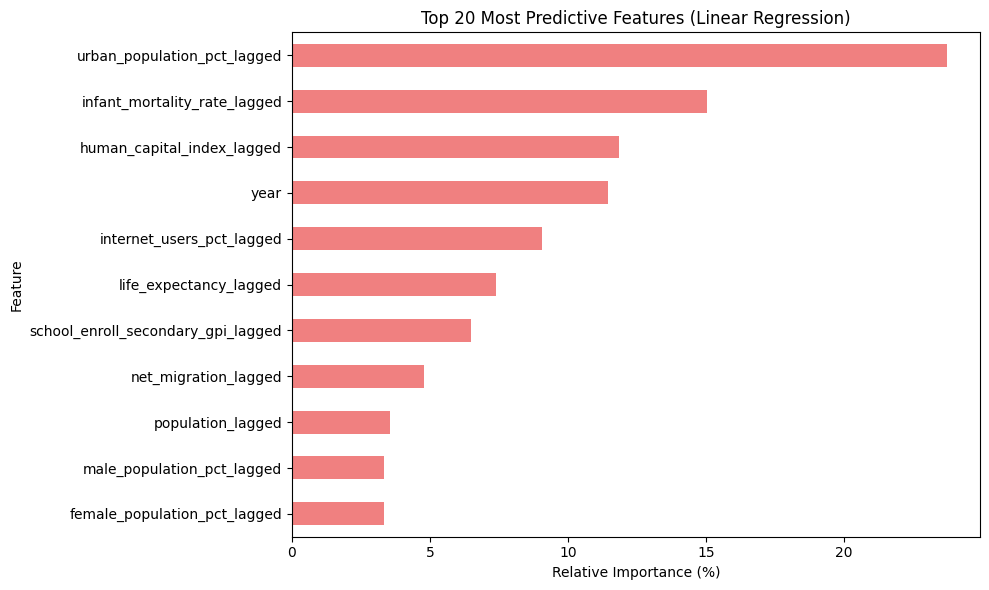

In [46]:
# -----------------------------
# 8. Plot feature importances
# -----------------------------
plt.figure(figsize=(10, 6))
importances_normalized.head(20).plot(kind="barh", color="lightcoral")
plt.title("Top 20 Most Predictive Features (Linear Regression)")
plt.xlabel("Relative Importance (%)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [47]:

# -----------------------------
# 9. Quick summary table
# -----------------------------
summary = pd.DataFrame({
    "Model": ["Linear Regression"],
    "RMSE": [mlr_rmse],
    "R²": [mlr_r2],
})
print("\nPerformance Summary:\n", summary)



Performance Summary:
                Model          RMSE        R²
0  Linear Regression  40412.471897 -2.476411
